# Semisopochnoi Island
---

This example notebook calculates and plots a path difference grid via [`calculate_paths_grid()`](https://infresnel.readthedocs.io/en/latest/#infresnel.infresnel.calculate_paths_grid) for a source located in the north crater of Mount Cerberus, on Semisopochnoi Island in the western Aleutian Islands of Alaska. Here, we use the default elevation source (1 arc-second SRTM data). We use `n_jobs=-2` to enable parallelization, with all but one CPU core being utilized (see joblib docs [here](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html)).

## Set up and calculate path grid

In [1]:
from infresnel import calculate_paths_grid

# North crater coordinates estimated using Google Earth
SRC_LAT, SRC_LON = 51.936, 179.586

# Grid parameters [m]
RADIUS = 5000
SPACING = 50

# Call function
path_length_differences, dem = calculate_paths_grid(
    src_lat=SRC_LAT, src_lon=SRC_LON, x_radius=RADIUS, y_radius=RADIUS, spacing=SPACING, n_jobs=-2,
)

Loading and projecting DEM...
Done

DEM spacing = 22.98 m -> profile spacing = 11.49 m

Fitting spline to DEM...
Done

Computing 40000 paths...


  0% |          | 0/40000 paths 

Done

Elapsed time = 6 s


## Create figure (optional)

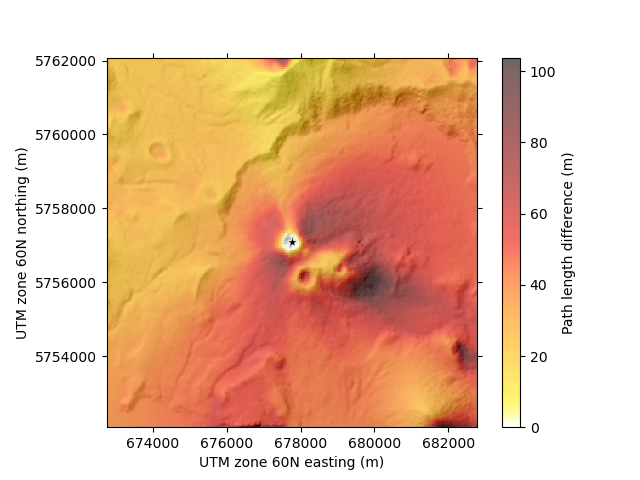

In [2]:
import colorcet as cc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pyproj import CRS, Transformer

# Reset everything to defaults
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Define projection
utm_crs = CRS(path_length_differences.rio.crs)
proj = Transformer.from_crs(utm_crs.geodetic_crs, utm_crs)

# Set up interactive Matplotlib
%matplotlib widget


# Format coordinates and grid values nicely for interactive use
def format_coord(x, y):
    lat, lon = proj.transform(x, y, direction='INVERSE')
    grid_value = path_length_differences.sel(x=x, y=y, method='nearest')
    return f'{x:.0f} m east, {y:.0f} m north ({lat:.3f}°, {lon:.3f}°)\n{grid_value:.3g} m'.replace(
        '-', '–'
    )


# Convert from pixel registration back to gridline registration for plotting
xvec, yvec = path_length_differences.x, path_length_differences.y
spacing = path_length_differences.spacing
xvec_plot = np.hstack([xvec, xvec[-1] + spacing]) - spacing / 2
yvec_plot = np.hstack([yvec, yvec[-1] - spacing]) + spacing / 2  # Note sign change!

# Plot
fig, ax = plt.subplots()
hs = dem.copy()
hs.data = matplotlib.colors.LightSource().hillshade(
    dem.data,
    dx=abs(dem.x.diff('x').mean().values),
    dy=abs(dem.y.diff('y').mean().values),
)
im = hs.plot.imshow(ax=ax, cmap='Greys_r', add_colorbar=False, add_labels=False)
qm = ax.pcolormesh(
    xvec_plot,
    yvec_plot,
    path_length_differences,
    cmap=cc.m_fire_r,
    shading='flat',
    alpha=0.6,
)
ax.scatter(*proj.transform(SRC_LAT, SRC_LON), marker='*', s=35, color='black', lw=0)
ax.set_aspect('equal')
ax.set_xlim(xvec_plot.min(), xvec_plot.max())
ax.set_ylim(yvec_plot.min(), yvec_plot.max())
ax.tick_params(top=True, right=True, which='both')
ax.set_xlabel(f'UTM zone {utm_crs.utm_zone} easting (m)')
ax.set_ylabel(f'UTM zone {utm_crs.utm_zone} northing (m)')
ax.ticklabel_format(style='plain')
ax.format_coord = format_coord
im.format_cursor_data = lambda data: ''  # Don't show hillshade data
fig.colorbar(qm, label='Path length difference (m)')
plt.show()